In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.5 MB/s eta 0:00:00


# **Neural Network**

Loading sequences from drive/MyDrive/LB2/second_try/SVM/Positive_training.fasta...
Loading sequences from drive/MyDrive/LB2/second_try/SVM/Negative_training.fasta...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20, Train Loss: 0.7022, Train Accuracy: 0.5338, Val Loss: 0.6627, Val Accuracy: 0.6761
Validation loss decreased (0.662741).  Saving model ...
Epoch 2/20, Train Loss: 0.6746, Train Accuracy: 0.5748, Val Loss: 0.6458, Val Accuracy: 0.6761
Validation loss decreased (0.645765).  Saving model ...
Epoch 3/20, Train Loss: 0.6589, Train Accuracy: 0.6022, Val Loss: 0.6220, Val Accuracy: 0.6985
Validation loss decreased (0.622037).  Saving model ...
Epoch 4/20, Train Loss: 0.6457, Train Accuracy: 0.6241, Val Loss: 0.6601, Val Accuracy: 0.6112
Epoch 5/20, Train Loss: 0.6369, Train Accuracy: 0.6403, Val Loss: 0.6151, Val Accuracy: 0.6578
Validation loss decreased (0.615071).  Saving model ...
Epoch 6/20, Train Loss: 0.6171, Train Accuracy: 0.6548, Val Loss: 0.6226, Val Accuracy: 0.6254
Epoch 7/20, Train Loss: 0.6121, Train Accuracy: 0.6644, Val Loss: 0.5955, Val Accuracy: 0.6566
Validation loss decreased (0.595460).  Saving model ...
Epoch 8/20, Train Loss: 0.5964, Train Accuracy: 0.6773,

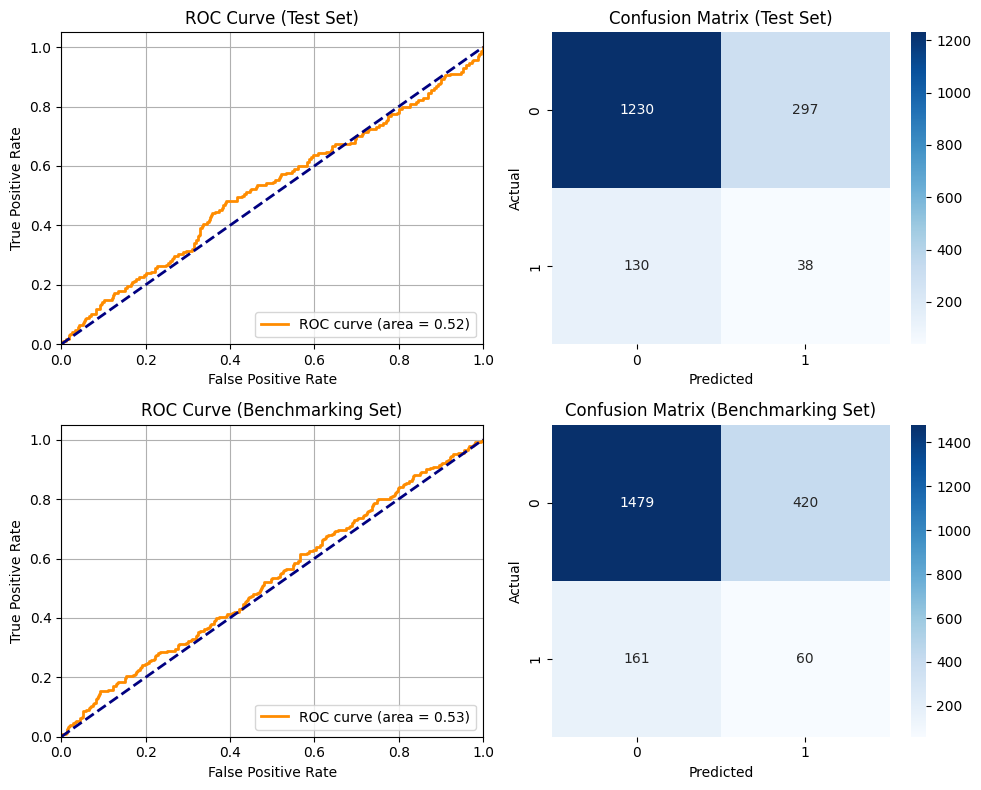

In [4]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from Bio import SeqIO
from sklearn.utils import shuffle, resample
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Define paths
base_path = Path('drive/MyDrive/LB2/second_try/SVM')
positive_training_fasta = base_path / 'Positive_training.fasta'
negative_training_fasta = base_path / 'Negative_training.fasta'
output_base_path = base_path / 'frequency_vectors'
benchmarking_positive_fasta = base_path / 'Positive_benchmarking.fasta'
benchmarking_negative_fasta = base_path / 'Negative_benchmarking.fasta'
output_base_path.mkdir(parents=True, exist_ok=True)

def load_fasta_sequences(fasta_path: Path) -> dict:
    """Load sequences from a fasta file."""
    print(f"Loading sequences from {fasta_path}...")
    return {record.id: str(record.seq) for record in SeqIO.parse(fasta_path, "fasta")}

positive_training_sequences = load_fasta_sequences(positive_training_fasta)
negative_training_sequences = load_fasta_sequences(negative_training_fasta)

def create_combined_dataframe(pos_seqs: dict, neg_seqs: dict) -> pd.DataFrame:
    """Create a combined DataFrame from positive and negative sequences."""
    positive_df = pd.DataFrame({'Sequence': list(pos_seqs.values()), 'Label': 1})
    negative_df = pd.DataFrame({'Sequence': list(neg_seqs.values()), 'Label': 0})
    combined_df = pd.concat([positive_df, negative_df], ignore_index=True)
    combined_df = shuffle(combined_df).reset_index(drop=True)
    return combined_df

combined_df = create_combined_dataframe(positive_training_sequences, negative_training_sequences)
subsets = np.array_split(combined_df, 5)

# Define train, validation, and test datasets
train_indices = [0, 1, 2]
val_index = 3
test_index = 4

train_data = pd.concat([subsets[i] for i in train_indices], ignore_index=True)
val_data = subsets[val_index]
test_data = subsets[test_index]

def handle_class_imbalance(df: pd.DataFrame) -> pd.DataFrame:
    """Handle class imbalance by oversampling the minority class."""
    train_majority = df[df.Label == 0]
    train_minority = df[df.Label == 1]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(train_majority), random_state=123)
    train_data_upsampled = pd.concat([train_majority, train_minority_upsampled])
    return shuffle(train_data_upsampled).reset_index(drop=True)

train_data_upsampled = handle_class_imbalance(train_data)

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i + 1 for i, aa in enumerate(amino_acids)}
max_sequence_length = 15

def encode_sequence(seq: str) -> list:
    """Encode a sequence of amino acids into integers."""
    return [aa_to_int.get(aa, 0) for aa in seq]

def encode_and_pad_sequences(df: pd.DataFrame, max_length: int = max_sequence_length) -> tuple:
    """Encode and pad sequences to a fixed length."""
    sequences = df['Sequence'].apply(encode_sequence).tolist()
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    labels = df['Label'].values
    return torch.tensor(padded_sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

X_train, y_train = encode_and_pad_sequences(train_data_upsampled)
X_val, y_val = encode_and_pad_sequences(val_data)
X_test, y_test = encode_and_pad_sequences(test_data)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=3000)
        self.fc2 = nn.Linear(in_features=3000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=50)
        self.fc4 = nn.Linear(in_features=50, out_features=10)
        self.fc5 = nn.Linear(in_features=10, out_features=1)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(3000)
        self.bn2 = nn.BatchNorm1d(1000)
        self.bn3 = nn.BatchNorm1d(50)
        self.bn4 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, criterion, and optimizer
input_size = max_sequence_length  # This should match the input size of the first layer
net = Net(input_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
            if self.verbose:
                print(f'Validation loss decreased ({self.best_loss:.6f}).  Saving model ...')
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def evaluate_model(model: nn.Module, data_loader: DataLoader) -> tuple:
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).float().sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, num_epochs: int = 20, learning_rate: float = 0.001):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
    early_stopping = EarlyStopping(patience=5, verbose=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).float().sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / total
        epoch_accuracy = correct / total
        val_loss, val_accuracy = evaluate_model(model, val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        scheduler.step(val_loss)
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    model.load_state_dict(early_stopping.best_model)

# Train the modified model
train_model(net, train_loader, val_loader)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(net, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Benchmark evaluation
benchmarking_positive_sequences = load_fasta_sequences(benchmarking_positive_fasta)
benchmarking_negative_sequences = load_fasta_sequences(benchmarking_negative_fasta)
benchmarking_df = create_combined_dataframe(benchmarking_positive_sequences, benchmarking_negative_sequences)
X_benchmark, y_benchmark = encode_and_pad_sequences(benchmarking_df)
benchmark_dataset = TensorDataset(X_benchmark, y_benchmark)
benchmark_loader = DataLoader(benchmark_dataset, batch_size=32, shuffle=False)
benchmark_loss, benchmark_accuracy = evaluate_model(net, benchmark_loader)
print(f'Benchmark Loss: {benchmark_loss:.4f}, Benchmark Accuracy: {benchmark_accuracy:.4f}')

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, ax, title: str = 'Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    tn, fp, fn, tp = cm.ravel()
    print(f'{title} - True Positives (TP): {tp}')
    print(f'{title} - True Negatives (TN): {tn}')
    print(f'{title} - False Positives (FP): {fp}')
    print(f'{title} - False Negatives (FN): {fn}')

def plot_roc_curve(y_true: np.ndarray, y_scores: np.ndarray, ax, title: str = 'ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True)

net.eval()
y_test_pred, y_test_scores = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        scores = torch.sigmoid(outputs)
        y_test_pred.extend(preds.cpu().numpy())
        y_test_scores.extend(scores.cpu().numpy())

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plot_roc_curve(y_test.cpu().numpy(), np.array(y_test_scores), ax=axes[0, 0], title='ROC Curve (Test Set)')
plot_confusion_matrix(y_test.cpu().numpy(), np.array(y_test_pred), ax=axes[0, 1], title='Confusion Matrix (Test Set)')

net.eval()
y_benchmark_pred, y_benchmark_scores = [], []
with torch.no_grad():
    for inputs, labels in benchmark_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        scores = torch.sigmoid(outputs)
        y_benchmark_pred.extend(preds.cpu().numpy())
        y_benchmark_scores.extend(scores.cpu().numpy())

plot_roc_curve(y_benchmark.cpu().numpy(), np.array(y_benchmark_scores), ax=axes[1, 0], title='ROC Curve (Benchmarking Set)')
plot_confusion_matrix(y_benchmark.cpu().numpy(), np.array(y_benchmark_pred), ax=axes[1, 1], title='Confusion Matrix (Benchmarking Set)')

plt.tight_layout()
plt.show()
